# 7.4 합성곱/풀링 계층 구현하기
# 7.4.1 4차원 배열

In [2]:
import numpy as np
x = np.random.rand(10, 1, 28, 28)  # 무작위 데이터 생성

In [3]:
x.shape

(10, 1, 28, 28)

In [4]:
x[0].shape

(1, 28, 28)

In [5]:
x[1].shape

(1, 28, 28)

## 7.4.3 합성곱 계층 구현하기

In [8]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [11]:
import sys, os
sys.path.append(os.pardir)
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7)    # (데이터 수, 채널 수, 높이, 너비)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

(9, 75)


In [12]:
x2 = np.random.rand(10, 3, 7, 7)    # 데이터 10개
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(90, 75)


In [13]:
class Consulution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        sel.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T   # 필터 전개
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        return out

In [14]:
class Poolint:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        sel.pad = pad
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 전개 (1)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        # 최댓값 (2)
        out = np.max(col, axis=1)
        
        # 성형 (3)
        out = out.reshpe(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out

## 7.4.4 풀링 계층 구현하기

In [1]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 전개 (1)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        # 최댓갑 (2)
        out = np.max(col, axis=1)
        
        # 성형 (3)
        out = out.shape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out

# 7.5 CNN 구현하기
- “Convolution-ReLU-Pooling-Affine-ReLU-Affine-Softmax” 순으로 흐르는 단순한 합성곱 신경망(CNN)입니다.
- SimpleConvNet으로 MNIST 데이터셋을 학습합니다.

In [3]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

train loss:2.2994582807281407
=== epoch:1, train acc:0.242, test acc:0.238 ===
train loss:2.2959218356808773
train loss:2.289701937817784
train loss:2.2782506888742162
train loss:2.2737238057671703
train loss:2.2585140285863994
train loss:2.2376957782042353
train loss:2.2217835319884816
train loss:2.1993104681820244
train loss:2.1726666874570797
train loss:2.1371434382367562
train loss:2.0880821846590325
train loss:2.0324871435333396
train loss:2.0078712730924426
train loss:1.883394221985196
train loss:1.8648245946732838
train loss:1.7620063718384629
train loss:1.6821863755253512
train loss:1.6578533440412582
train loss:1.5088511067668602
train loss:1.4949602719209432
train loss:1.4237215589196044
train loss:1.3180568700390105
train loss:1.2240356003102146
train loss:1.1687577546963706
train loss:1.389800537204415
train loss:1.1195212763313849
train loss:0.9502667369598342
train loss:1.0269164559131514
train loss:0.8923465439504671
train loss:0.9079854113414825
train loss:0.71117019754

train loss:0.33569139853120994
train loss:0.18002306917457578
train loss:0.3055820986503982
train loss:0.16923385906536492
train loss:0.3645874756085098
train loss:0.22682678930355027
train loss:0.251993628542234
train loss:0.1245267450701613
train loss:0.1970563727391443
train loss:0.21603473698081274
train loss:0.19979617710805336
train loss:0.21432881617882116
train loss:0.25803112675125883
train loss:0.22545783623982377
train loss:0.241303966125314
train loss:0.16736995833611423
train loss:0.5162470543066161
train loss:0.29172354162881164
train loss:0.2683394856888997
train loss:0.13513399564842973
train loss:0.20540456463674928
train loss:0.2032632107404681
train loss:0.23677699560467735
train loss:0.20982925529497337
train loss:0.3530516618333646
train loss:0.20973875793081537
train loss:0.18095064410612674
train loss:0.11346654277409755
train loss:0.20695358753752707
train loss:0.2277402192481452
train loss:0.2174045839012237
train loss:0.21346668813073755
train loss:0.135332747

train loss:0.1395942254644691
train loss:0.13110930501537713
train loss:0.13409674963356577
train loss:0.0918884331490616
train loss:0.1865349656007512
train loss:0.1151676468249786
train loss:0.19105833454461899
train loss:0.08082486030658856
train loss:0.11452908325064967
train loss:0.2131480869122452
train loss:0.15928068772668313
train loss:0.19599568023540026
train loss:0.1425509212909091
train loss:0.16962205233258237
train loss:0.08189853277626154
train loss:0.08150694469846295
train loss:0.09778255354793756
train loss:0.1864946525142309
train loss:0.041761723816310804
train loss:0.27261427493246104
train loss:0.22703940842428794
train loss:0.12718881415628153
train loss:0.06629434941152172
train loss:0.08999820173685111
train loss:0.2198242592489477
train loss:0.2250108638764401
train loss:0.12456451816569672
train loss:0.09432365391277511
train loss:0.06092670971526738
train loss:0.12427106892222865
train loss:0.15401198829493049
train loss:0.08051153439884906
train loss:0.106

train loss:0.06252266328643422
train loss:0.08573621762435074
train loss:0.039253406251955544
train loss:0.03797843379269722
train loss:0.07645853048664444
train loss:0.08291916163809716
train loss:0.09921090749631847
train loss:0.1529386327246171
train loss:0.15161731807273202
train loss:0.09793434024257147
train loss:0.09580258287896054
train loss:0.15665511423140216
train loss:0.04496794898283046
train loss:0.07549411752354519
train loss:0.11722097118986953
train loss:0.07488691653902539
train loss:0.06732601994954361
train loss:0.08994656578536533
train loss:0.05525012642342726
train loss:0.11638123906493927
train loss:0.058235187765220395
train loss:0.10390989673054438
train loss:0.06024038974186789
train loss:0.11505980132335852
train loss:0.06946597047673553
train loss:0.05090070311661276
train loss:0.0692648037096258
train loss:0.042691549860123426
train loss:0.13701509826125546
train loss:0.08498957606000772
train loss:0.05234868171983376
train loss:0.07946632869109412
train l

train loss:0.05050910881028143
train loss:0.059838880618460176
train loss:0.06212132318277362
train loss:0.16842408279454746
train loss:0.07008664240266554
train loss:0.031892925705710645
train loss:0.057577497575197055
train loss:0.15897362522760408
train loss:0.11288721817421737
train loss:0.025725509798575366
train loss:0.0804613172868704
train loss:0.010092713625804885
train loss:0.04901703342979685
train loss:0.06321910303846275
train loss:0.06213365731996113
train loss:0.01523906554505986
train loss:0.03331674895717842
train loss:0.054221089293997354
train loss:0.13941755119926336
train loss:0.016589581025250186
train loss:0.03173848225502403
train loss:0.055733226947410106
train loss:0.05893221844821827
train loss:0.07992185979651975
train loss:0.0749734674564808
train loss:0.055857427867641335
train loss:0.090939973300536
train loss:0.07304816409447767
train loss:0.02608439036916295
train loss:0.040972064055337036
train loss:0.043444960350991074
train loss:0.03113022709053475
t

train loss:0.0815623081254953
train loss:0.09237274795461695
train loss:0.10484011786123172
train loss:0.06790135990656872
train loss:0.037825943758992245
train loss:0.08126097069323002
train loss:0.06317350808927105
train loss:0.08186414016320899
train loss:0.028266387740308593
train loss:0.042713680367017164
train loss:0.057593174504014376
train loss:0.05501357661891282
train loss:0.11308962080920613
train loss:0.08952173111621678
train loss:0.06647923538955901
train loss:0.08770675829820872
train loss:0.04544455746060346
train loss:0.06226550288932276
train loss:0.026822290114613262
train loss:0.08378209507087671
train loss:0.038955995665360794
train loss:0.0746234606418558
train loss:0.043421471350325085
train loss:0.05153980349726202
train loss:0.031823277390753815
train loss:0.030894299889754836
train loss:0.04555907405344325
train loss:0.12582894923157883
train loss:0.05798039601307987
train loss:0.09036420597682845
train loss:0.050174137790230985
train loss:0.018198907398878538

train loss:0.027363781773640863
train loss:0.02367016854407606
train loss:0.06977250810334772
train loss:0.013435311959970624
train loss:0.04920745260848358
train loss:0.025647951981285177
train loss:0.08500053514739556
train loss:0.021211167381471007
train loss:0.012667517119075327
train loss:0.04675138602525557
train loss:0.027251515108760026
train loss:0.012528586561705501
train loss:0.07544016563813978
train loss:0.06122314454259778
train loss:0.10179348053049059
train loss:0.040287510295638235
train loss:0.016882384745203288
train loss:0.039479569040979004
train loss:0.04145200116650427
train loss:0.01976481890955883
train loss:0.0373076990889514
train loss:0.009997088796779057
train loss:0.05868013900503169
train loss:0.013256878290092618
train loss:0.024421452313229407
train loss:0.029272630783219348
train loss:0.01211200616249643
train loss:0.041471118879295464
train loss:0.1057578412256105
train loss:0.08347020240322321
train loss:0.04692121972774104
train loss:0.0531877082421

train loss:0.030918882066081007
train loss:0.03190454303423036
train loss:0.03371099929459438
train loss:0.03747216493726874
train loss:0.0448758854135286
train loss:0.028988132116827613
train loss:0.01664579908077961
train loss:0.017541717784613883
train loss:0.02664585099795377
train loss:0.07202880666602393
train loss:0.043400026507621876
train loss:0.01506667209450083
train loss:0.029161762153390856
train loss:0.03308614831590652
train loss:0.019667212461379265
train loss:0.0429642425457887
train loss:0.015489054468872639
train loss:0.02153639675410768
train loss:0.01674373424122902
train loss:0.08051172921943138
train loss:0.019390080340501003
train loss:0.02680471275313459
train loss:0.040187469767152845
train loss:0.07486855390357769
train loss:0.009831396104887726
train loss:0.053850617854837315
train loss:0.12607934577083366
train loss:0.02741760266271817
train loss:0.04926810966470319
train loss:0.023143790504277346
train loss:0.11969695868809022
train loss:0.0321527797778510

train loss:0.029117062466183806
train loss:0.02118090646432345
train loss:0.028161349692915755
train loss:0.023423137565314625
train loss:0.02028706152533414
train loss:0.04205752434373387
train loss:0.06163665986346363
train loss:0.02590197916495747
train loss:0.015098187961464013
train loss:0.0264912355923773
train loss:0.01586069056973227
train loss:0.030293933768931032
train loss:0.010952514623914658
train loss:0.027350883682242682
train loss:0.029670899934760898
train loss:0.03688044544107951
train loss:0.04715860997350741
train loss:0.08564572412335453
train loss:0.03698521721648934
train loss:0.0733668466262178
train loss:0.06585898924051022
train loss:0.05330162989807881
train loss:0.0024547687893589553
train loss:0.08410336252619159
train loss:0.030695927874927906
train loss:0.07345461171337607
train loss:0.007034183417476563
train loss:0.05906906734301405
train loss:0.026509816900157065
train loss:0.03477900370914031
train loss:0.05109373932037948
train loss:0.027631162092340

train loss:0.056398460362591434
train loss:0.012215936557317317
train loss:0.07428285808906938
train loss:0.007162111808800158
train loss:0.004276478101049141
train loss:0.052645766830369006
train loss:0.11781278619427299
train loss:0.03808483324054083
train loss:0.02159725586740283
train loss:0.06299873557784273
train loss:0.07400181408420581
train loss:0.007662249439413262
train loss:0.03769032026000617
train loss:0.02811359180654489
train loss:0.06584275027338055
train loss:0.019127082295954435
train loss:0.03866181807967008
train loss:0.0386836176944098
train loss:0.018977638473436306
train loss:0.013400215243624017
train loss:0.09190638642155272
=== epoch:5, train acc:0.987, test acc:0.981 ===
train loss:0.005411282995738926
train loss:0.034348344048946294
train loss:0.038575840526344746
train loss:0.02429776023344657
train loss:0.020525623492447145
train loss:0.027926733694650055
train loss:0.015166834301572247
train loss:0.030064482591690617
train loss:0.09048519592554789
train 

train loss:0.03243574193499991
train loss:0.04116018568021767
train loss:0.007995225337528031
train loss:0.05860608402372375
train loss:0.0656812544630884
train loss:0.0913102380536094
train loss:0.08235282637265878
train loss:0.0125407787537409
train loss:0.0181831396307688
train loss:0.013276255247985829
train loss:0.021835320919751208
train loss:0.01352322793492935
train loss:0.03622378405811811
train loss:0.016224744406899316
train loss:0.05982300403934406
train loss:0.014833264751136001
train loss:0.06009387741388372
train loss:0.017997814066606693
train loss:0.018959652069055796
train loss:0.022015266003574223
train loss:0.016870922709155484
train loss:0.014580700091880257
train loss:0.06605982794453602
train loss:0.0070121290908466884
train loss:0.012308401308182502
train loss:0.046858002597157285
train loss:0.014234814687099293
train loss:0.07525095821981717
train loss:0.024266469225704194
train loss:0.020050292378991853
train loss:0.052754590702405284
train loss:0.010451055014

train loss:0.0165615161654378
train loss:0.019755273614815074
train loss:0.023057575688988072
train loss:0.01314251818129299
train loss:0.016156413364608036
train loss:0.02212941799802981
train loss:0.00577830243768243
train loss:0.06430889495652242
train loss:0.006032355457012465
train loss:0.020427924959748097
train loss:0.023617925350815812
train loss:0.04812529809510524
train loss:0.01857979323072755
train loss:0.025870390325168004
train loss:0.01316191225692134
train loss:0.034222892064116835
train loss:0.013675756001997719
train loss:0.009993534722681325
train loss:0.0019591577942865003
train loss:0.006580772732503477
train loss:0.018776337632714284
train loss:0.01521177352729473
train loss:0.005991720956148532
train loss:0.03781201747067917
train loss:0.017128186967747597
train loss:0.03697988027560082
train loss:0.012715554766815742
train loss:0.018635478404462183
train loss:0.008167106532314668
train loss:0.011893828898909924
train loss:0.021941430767049325
train loss:0.008094

train loss:0.0028405288298230407
train loss:0.024547738736066235
train loss:0.003924758364041593
train loss:0.056376919529803365
train loss:0.003387385945913553
train loss:0.09103946613184657
train loss:0.013338691596985081
train loss:0.013613588400291657
train loss:0.04890462590120582
train loss:0.01039485865936615
train loss:0.013909374851854579
train loss:0.03134891944145097
train loss:0.014006225951403432
train loss:0.02036350365661922
train loss:0.003370769244781514
train loss:0.003478990375501097
train loss:0.051838589696354714
train loss:0.029851973642042746
train loss:0.03872023218812563
train loss:0.04883150723021235
train loss:0.01069360291199347
train loss:0.009135142418253011
train loss:0.013661144999236161
train loss:0.024232180032318223
train loss:0.012157013198870841
train loss:0.009087496551305502
train loss:0.005911559592916331
train loss:0.01140805051306915
train loss:0.02354387302866101
train loss:0.03435754965733363
train loss:0.036404704173838204
train loss:0.00961

train loss:0.026044647551715032
train loss:0.026149288196808052
train loss:0.02032123461910169
train loss:0.009683916407296093
train loss:0.011776508421332129
train loss:0.019599418457118326
train loss:0.008535491132215498
train loss:0.006835093409858598
train loss:0.007162576124557556
train loss:0.05345486543536379
train loss:0.02440246114990733
train loss:0.011695557343241268
train loss:0.011677192235214
train loss:0.01749301475344825
train loss:0.07637155742943491
train loss:0.01753981049171907
train loss:0.019915230152182682
train loss:0.012121250879938997
train loss:0.012505358721583155
train loss:0.005243918513710508
train loss:0.0059343878514590154
train loss:0.0139222695998516
train loss:0.0582154400802585
train loss:0.032928004239564615
train loss:0.007487435439947635
train loss:0.007357501334951038
train loss:0.0024755621669369783
train loss:0.025831602467473257
train loss:0.008590803817714572
train loss:0.01058371528974611
train loss:0.004518638464885327
train loss:0.0105267

train loss:0.006009531388473158
train loss:0.009664691590047651
train loss:0.005048415741815745
train loss:0.0067780174180418
train loss:0.019277632430281605
train loss:0.006390930114633736
train loss:0.014822413158743917
train loss:0.044692637917482625
train loss:0.008381889165868055
train loss:0.003832358689364631
train loss:0.0020363115649220144
train loss:0.01370098803641792
train loss:0.0023749679360897005
train loss:0.009452642140129341
train loss:0.011314750475368552
train loss:0.0123627316787948
train loss:0.016430820680923493
train loss:0.0032994186058655315
train loss:0.0034876460959052946
train loss:0.002809966656956136
train loss:0.008105859813624341
train loss:0.0025827614549052908
train loss:0.046213999244363604
train loss:0.06791797563337704
train loss:0.015853538499820827
train loss:0.021414382144685117
train loss:0.013635140181782423
train loss:0.007948790596058351
train loss:0.09655886603094072
train loss:0.014690507382462055
train loss:0.007867869709120495
train loss

train loss:0.003949580273180943
train loss:0.004944025319641698
train loss:0.01219476280537529
train loss:0.003422915993727605
train loss:0.0012309346831391628
train loss:0.01452196482281564
train loss:0.003082614033064626
train loss:0.005266290624489312
train loss:0.004045265284418027
train loss:0.01020701448194997
train loss:0.041775921560267576
train loss:0.006224880229626032
train loss:0.07384702445361536
train loss:0.022570489231727144
train loss:0.028233638958069802
train loss:0.004767052879068566
train loss:0.0027802778977635877
train loss:0.008476954079778116
train loss:0.004832161337075284
train loss:0.17015372763481043
train loss:0.014139812068786374
train loss:0.00517154221571672
train loss:0.005928969348592839
train loss:0.016764598896008273
train loss:0.001197707008388456
train loss:0.02172494156913276
train loss:0.02744639279360169
train loss:0.006636276043886808
train loss:0.0051511129051531246
train loss:0.00971543501878282
train loss:0.015436869718919593
train loss:0.0

train loss:0.012312423547333888
train loss:0.0018039800434920116
train loss:0.005882921333672374
train loss:0.004231263217520952
train loss:0.0030404312479010032
train loss:0.0045605253886168914
train loss:0.006762373821644516
train loss:0.017984125143004244
train loss:0.0016500988065330186
=== epoch:8, train acc:0.987, test acc:0.98 ===
train loss:0.04204537579793613
train loss:0.01692108939616748
train loss:0.013430452598682302
train loss:0.004584506417981347
train loss:0.005853608139531988
train loss:0.006535591900286816
train loss:0.014327558732002497
train loss:0.033347484831859814
train loss:0.02469011622532495
train loss:0.009182985492388933
train loss:0.010269125942597834
train loss:0.021048806666877286
train loss:0.009544812734280542
train loss:0.000740505152760951
train loss:0.01970931960518856
train loss:0.01593410775422509
train loss:0.002389985042259871
train loss:0.008966229413833064
train loss:0.01282565249564073
train loss:0.0016938453659788733
train loss:0.006584413330

train loss:0.011922561575148406
train loss:0.008326653497146081
train loss:0.003304519510130727
train loss:0.0009853418345784168
train loss:0.019811271214996862
train loss:0.007470029770471558
train loss:0.0036635682468563265
train loss:0.0038993549645046288
train loss:0.0023672511316596774
train loss:0.005818638435802739
train loss:0.04574477751345942
train loss:0.004196524657952825
train loss:0.007606648033974623
train loss:0.09491266802862972
train loss:0.026405044245459232
train loss:0.01678517902170219
train loss:0.016859354634734747
train loss:0.00495554857320071
train loss:0.004227390558873079
train loss:0.03867601975866563
train loss:0.054884356064776416
train loss:0.011047482284539072
train loss:0.02358116766773569
train loss:0.0017934100442338816
train loss:0.034648455189675846
train loss:0.0047242132964123
train loss:0.009631438860753539
train loss:0.004204428297129179
train loss:0.002684509975214257
train loss:0.012500123714752414
train loss:0.010833925259742581
train loss:

train loss:0.0022719748150377772
train loss:0.014214021646125816
train loss:0.04365636799170849
train loss:0.0034558001329208134
train loss:0.0015770106146438603
train loss:0.0033501794076155485
train loss:0.004176133558803694
train loss:0.010143393965222108
train loss:0.01499114576513448
train loss:0.07226030962262316
train loss:0.007473534719949847
train loss:0.005841993409140619
train loss:0.020875127488895914
train loss:0.021771387685091636
train loss:0.03991958764177972
train loss:0.010840156786575952
train loss:0.0034277643153108983
train loss:0.010145604514405621
train loss:0.007416452114293052
train loss:0.005590132917946653
train loss:0.03006936324823576
train loss:0.000776080034887443
train loss:0.008061066994926223
train loss:0.01303903410621694
train loss:0.011948365608358292
train loss:0.00677665340288504
train loss:0.003227998968081062
train loss:0.001955270750997697
train loss:0.004021828741460269
train loss:0.034126544003742154
train loss:0.006294011032700792
train loss

train loss:0.0024823924385081963
train loss:0.015455951699790407
train loss:0.005202622421218349
train loss:0.004890773800293996
train loss:0.003472044923539212
train loss:0.014992926002151572
train loss:0.0012505553287472013
train loss:0.0016533182033190953
train loss:0.005450014018615762
train loss:0.009602753053350734
train loss:0.014384459742224874
train loss:0.006720973463367944
train loss:0.012546939568359288
train loss:0.0009560052838739851
train loss:0.008029788872445045
train loss:0.0018137935729736659
train loss:0.010083910650015182
train loss:0.010879002347382922
train loss:0.00831685457410094
train loss:0.0016889077035150786
train loss:0.08495494595666836
train loss:0.012361130279921728
train loss:0.00408904498304352
train loss:0.023246496574229218
train loss:0.0035964533918871745
train loss:0.007402553157234712
train loss:0.003882373508163308
train loss:0.007343898853259755
train loss:0.0020817724173338927
train loss:0.002378569881492506
train loss:0.011771250292068458
tra

train loss:0.002935962153776706
train loss:0.004492867071958214
train loss:0.0022247773161689684
train loss:0.009945788897927434
train loss:0.004007082023373288
train loss:0.002827553515341528
train loss:0.024174631738411775
train loss:0.0024725997257819014
train loss:0.0024440031809402287
train loss:0.0055200938188380766
train loss:0.0044126868293215705
train loss:0.00885593057570638
train loss:0.002342411109751538
train loss:0.0051421411095581284
train loss:0.002470757955063646
train loss:0.01748385399482943
train loss:0.022405263233811847
train loss:0.011602962857929165
train loss:0.01560577457809086
train loss:0.0015657676812452562
train loss:0.0005081903351065162
train loss:0.0145047953332528
train loss:0.0029415859301194992
train loss:0.011915622289443777
train loss:0.007936596844812524
train loss:0.012956453008093928
train loss:0.004556873508212595
train loss:0.0034478254331316827
train loss:0.003397926427675176
train loss:0.013025972662598053
train loss:0.01374729126589522
trai

train loss:0.02371863386330246
train loss:0.0018942481422526412
train loss:0.0024223626242833316
train loss:0.0017534715734080887
train loss:0.004861730864149583
train loss:0.021627607356888706
train loss:0.008168545741979066
train loss:0.003580741791330087
train loss:0.028441690151348252
train loss:0.0052956000821610385
train loss:0.004583196894664586
train loss:0.00505000392395567
train loss:0.019150685621771774
train loss:0.007522627283847225
train loss:0.0019844507052517958
train loss:0.004687547597794651
train loss:0.02028128707119831
train loss:0.0027142195814609626
train loss:0.0036449911877746368
train loss:0.009289471183973093
train loss:0.007243012653807402
train loss:0.006288149203167811
train loss:0.0050769387620196674
train loss:0.000829352999100422
train loss:0.005115576277834577
train loss:0.00790224098614369
train loss:0.0008301045775961735
train loss:0.001678455866281658
train loss:0.00795603622890942
train loss:0.007709251489376955
train loss:0.0011023565506284715
tra

train loss:0.008401677786273352
train loss:0.004427063384854154
train loss:0.006861677683444753
train loss:0.006077105122047792
train loss:0.008285993882710938
train loss:0.011454584993464018
train loss:0.007731658756789752
train loss:0.03839087030817381
train loss:0.0043666669621649215
train loss:0.0029191235248875835
train loss:0.0029444039617332273
train loss:0.00511330914167443
train loss:0.00656599026416953
train loss:0.019447976268285188
train loss:0.0029754311192850946
train loss:0.004678433844883555
train loss:0.012878449140140547
train loss:0.010052852197800994
train loss:0.00659879728192901
train loss:0.03690653829114174
train loss:0.0022431084268586094
train loss:0.06961182324742173
train loss:0.009771297576520052
train loss:0.0019446548686328077
train loss:0.010938357155240956
train loss:0.013997170030309047
train loss:0.0670724101015427
train loss:0.006506520808029917
train loss:0.001344137503300786
train loss:0.004610217071235886
train loss:0.004356268616072576
train loss

train loss:0.002248370687210934
train loss:0.0010358133353011438
train loss:0.0013997292871412515
train loss:0.004090072560902038
train loss:0.00153945105394912
train loss:0.0213726178594869
train loss:0.005140711337713959
train loss:0.0018009492937368437
train loss:0.006243333697363168
train loss:0.01400322585107369
train loss:0.001260257833945281
train loss:0.000649609589946009
train loss:0.010002458205162094
train loss:0.006237214570005193
train loss:0.002638607371795966
=== epoch:11, train acc:0.997, test acc:0.982 ===
train loss:0.0014724312379223773
train loss:0.00833618340968177
train loss:0.014591085066956857
train loss:0.0028443068897571907
train loss:0.000846558919825169
train loss:0.0018558338110820248
train loss:0.0005761316073222829
train loss:0.004668284439070139
train loss:0.002519358648523593
train loss:0.003990767083204942
train loss:0.004152712641813411
train loss:0.008968408782985006
train loss:0.0031823472198088455
train loss:0.011485418389419322
train loss:0.006997

train loss:0.000625885286760247
train loss:0.00310528412962837
train loss:0.00411467152134792
train loss:0.0021940946349140295
train loss:0.007561578736238305
train loss:0.002714334005759673
train loss:0.006021120135584085
train loss:0.0003797790467254385
train loss:0.006844456744031118
train loss:0.0047258280844304345
train loss:0.00017647159985499327
train loss:0.000873846573056965
train loss:0.007631102875810523
train loss:0.0012936969507342875
train loss:0.00559083727551666
train loss:0.0016852386129217287
train loss:0.008026672372592396
train loss:0.003816934382664016
train loss:0.007394937311778708
train loss:0.00048073389047328366
train loss:0.003131654370335435
train loss:0.0005472141861457866
train loss:0.003913793605148378
train loss:0.007492240886208052
train loss:0.0018974235159235622
train loss:0.016319681771864693
train loss:0.004573591753144258
train loss:0.001871482969742616
train loss:0.0008817511414601429
train loss:0.004825071552691463
train loss:0.001655685712084334

train loss:0.009726823055139276
train loss:0.0006421694488504564
train loss:0.0007460216652558226
train loss:0.001794220255659478
train loss:0.003444911701407522
train loss:0.008085963385501238
train loss:0.0017085048035864825
train loss:0.0027379274985867607
train loss:0.010581050615126026
train loss:0.0005459908609472727
train loss:0.02154636354727069
train loss:0.002068996246975381
train loss:0.0011158125868133747
train loss:0.000177916363985151
train loss:0.004475623277296683
train loss:0.0034958610232086267
train loss:0.0502863588051369
train loss:0.0025464391242667854
train loss:0.017174386769070724
train loss:0.001946615575971793
train loss:0.0024818358041948417
train loss:0.0047699957402018425
train loss:0.013230649289876164
train loss:0.0013351251346175718
train loss:0.009364209603978782
train loss:0.003973615315511393
train loss:0.013322520267447702
train loss:0.011389827827357485
train loss:0.0008661101262568295
train loss:0.0003337272714087054
train loss:0.00399013375308120

train loss:0.005401236537566257
train loss:0.008931805921516852
train loss:0.006109756290901448
train loss:0.0065006431570181315
train loss:0.021000957667850498
train loss:0.003437375257347162
train loss:0.002702825049991428
train loss:0.001621687770464514
train loss:0.004226310506024396
train loss:0.030930886179308746
train loss:0.005968545238292466
train loss:0.0006967831867857209
train loss:0.010206779894319323
train loss:0.0037186386684966975
train loss:0.006982269248992589
train loss:0.0031190346032732713
train loss:0.006555797500908679
train loss:0.013611263410923303
train loss:0.001303862393400259
train loss:0.00037558898398580516
train loss:0.0043959464160898305
train loss:0.0018462318098962365
train loss:0.0016981772645735815
train loss:0.007723076169177321
train loss:0.009412462144499261
train loss:0.003050489875247366
train loss:0.0025258482117021656
train loss:0.001461350021086322
train loss:0.013635878121683521
train loss:0.002647147611598614
train loss:0.01996807916565374

train loss:0.04283476010258447
train loss:0.005042665890555898
train loss:0.002349752993744449
train loss:0.002461893053600983
train loss:0.023646968719597757
train loss:0.005373544637372075
train loss:0.0037602244636976796
train loss:0.007472709951111025
train loss:0.0028803761044642264
train loss:0.03269390500937143
train loss:0.001646519075326771
train loss:0.004175037922793008
train loss:0.005391026762202408
train loss:0.008111884007815042
train loss:0.0076061872923716845
train loss:0.007617702616289193
train loss:0.0065271157638618574
train loss:0.0006385739476652432
train loss:0.04792756383480112
train loss:0.005046972511175996
train loss:0.0017724245712868278
train loss:0.012723256925181671
train loss:0.003642015923320644
train loss:0.006475227990633021
train loss:0.0028940076601305436
train loss:0.0014004495913234503
train loss:0.0036987324169263903
train loss:0.0041634731725921385
train loss:0.0021827112305822555
train loss:0.0018469797082253808
train loss:0.004265033024151929

train loss:0.002482822224431249
train loss:0.0018426880294087774
train loss:0.0004831694813863057
train loss:0.0014307925388332685
train loss:0.003974855291955412
train loss:0.014317818798399383
train loss:0.011585527177495425
train loss:0.006105150757921543
train loss:0.0012610916095761634
train loss:0.004144585586893721
train loss:0.001271269725777077
train loss:0.0023912018501745895
train loss:0.004544662219326103
train loss:0.026353259619713666
train loss:0.0008667981074898312
train loss:0.0008693521890713709
train loss:0.0005350959271800111
train loss:0.0012946272111456082
train loss:0.006914366329506293
train loss:0.005206534806760626
train loss:0.0023912813983914694
train loss:0.0055543750184218
train loss:0.004545258229888112
train loss:0.007194403616286902
train loss:0.0013184328949649752
train loss:0.0037725787970822005
train loss:0.004116775812003947
train loss:0.005765054784852937
train loss:0.0010388507444586339
train loss:0.0005758813859170919
train loss:0.000705972715237

train loss:0.005172119843483821
train loss:0.002960334034163094
train loss:0.0004302393943433811
train loss:0.01118060202422874
train loss:0.0036025665550401364
train loss:0.0011607574911050604
train loss:0.002437672836040543
train loss:0.011404139996406406
train loss:0.0003253524963756408
train loss:0.009706928577142938
train loss:0.004490724092169692
train loss:0.0018045602528446272
train loss:0.0036400640126186003
train loss:0.0014829767534849155
train loss:0.014649503896972577
train loss:0.015297746411822202
train loss:0.003500022496763535
train loss:0.0016897836716977263
train loss:0.0032800960589377316
train loss:0.0020282865030119045
train loss:0.0018675760253131653
train loss:0.03673536342794876
train loss:0.001705141318145123
train loss:0.0012130176514959603
train loss:0.007180254053951643
train loss:0.0014588466301506753
train loss:0.004318956655434521
train loss:0.007156522862934664
train loss:0.0018377392417346131
train loss:0.0024214428542554236
train loss:0.00316391896998

train loss:0.0024619008859617943
train loss:0.0044031710989760105
train loss:0.0009645375627437716
train loss:0.008143517784517405
train loss:0.003715708271316796
train loss:0.0005802108104499626
train loss:0.0005510660166440242
train loss:0.008184863029135877
train loss:0.002709192207775049
train loss:0.0005741768355514737
train loss:0.001023554383350541
train loss:0.008459504909290722
train loss:0.004778642242248427
train loss:0.0036612471378594125
train loss:0.0038366063977193334
train loss:0.002180300370316321
train loss:0.0007450775074089592
train loss:0.004194570057683913
train loss:0.0006937921172865883
train loss:0.0013829064205002671
train loss:0.0006885418068014206
train loss:0.0006620596657882456
train loss:0.009546385863016845
train loss:0.0032652982538182405
train loss:0.0062324503944407
train loss:0.0016139461249738663
train loss:0.0007846657530917209
train loss:0.0007153754410930236
train loss:0.0016347334807566925
train loss:0.007257919018517823
train loss:0.00104729702

train loss:0.0030860206047547325
train loss:0.0003039846487049503
train loss:0.0027521573357738244
train loss:0.001567450917266395
train loss:0.00038877809582497875
train loss:0.009554060363363707
train loss:0.0008694396484842238
train loss:0.025319849790497385
train loss:0.008641195503087767
train loss:0.00316973420153358
train loss:0.005292634534904398
train loss:0.007381625107611412
train loss:0.0035034568152888944
train loss:0.0021091517381157734
train loss:0.00022649411174959324
train loss:0.003327557819867074
train loss:0.0013238277791109338
train loss:0.00015459744625605736
train loss:0.0008334941630227786
train loss:0.0011764080773719278
train loss:0.00014710713773906402
train loss:0.00035958629219385517
train loss:0.004443327876908051
train loss:0.0023668900245700938
train loss:0.0016216118633562062
train loss:0.006967189867405039
train loss:0.0015061021653425784
train loss:0.007679602236873912
train loss:0.001151199902227181
train loss:0.001042534047378888
train loss:0.005876

train loss:0.00448884021166937
train loss:0.0016922173088617374
train loss:0.0013638349273202665
train loss:0.0012100996871245407
train loss:0.0007816645620785514
train loss:0.0007151776691557777
train loss:0.00173029411622663
train loss:0.0008867554403332678
train loss:0.0005344949898378826
train loss:0.0015787437435623097
train loss:0.0008205730022853258
train loss:0.0008438257649032928
train loss:0.002215583679929729
train loss:0.0005306965567482659
train loss:0.002197260684520304
train loss:0.0013377749480091652
train loss:0.00036831088576590095
train loss:0.015202500267321941
train loss:0.0006894297174209265
train loss:0.0002574858976012156
train loss:0.0012926742778793722
train loss:0.001468953907651029
train loss:0.024323773456390706
train loss:0.00022264290996130913
train loss:0.0039437889133602
train loss:0.002876250509848935
train loss:0.004374634327748165
train loss:0.004090866571089442
train loss:0.005634651265728952
train loss:0.006100477331369116
train loss:0.000717016174

train loss:0.0050137906411424835
train loss:0.001159244878066834
train loss:0.006540871462905562
train loss:0.0010943967402813433
train loss:0.000728740570894304
train loss:0.005477670760685337
train loss:0.00695705088175956
train loss:0.009785569963325337
train loss:0.01225173912831593
train loss:0.0015706892606855644
train loss:0.004173206831491271
train loss:0.005413138163589734
train loss:0.0025399617450204918
train loss:0.0010582539223511695
train loss:0.0032826051895811803
train loss:0.0020033001123844914
train loss:0.001045298516968328
train loss:0.0028394392521091157
train loss:0.002110043511339407
train loss:0.001109937050401847
train loss:0.0015170983376925104
train loss:0.0411874946178711
train loss:0.004279131100941696
train loss:0.0026646031222342104
train loss:0.0007899367977056733
train loss:0.0032631266824207196
train loss:0.0008490986286663065
train loss:0.0020085081964682596
train loss:0.0018159215783171189
train loss:0.001386234469927709
train loss:0.0036247739673833

train loss:7.108372540958698e-05
train loss:0.0006118543777577215
train loss:7.733700835878844e-05
train loss:8.532459176532909e-05
train loss:0.0008121061581559071
train loss:0.0016064456710334937
train loss:0.00044921507077074385
train loss:0.00795934004857992
train loss:0.0004884567374737358
train loss:0.0016100262805347045
train loss:0.0005271484443771833
train loss:0.0005520010193955964
train loss:0.002685716437137158
train loss:0.001509302259875942
train loss:0.0002411578105417555
train loss:0.000978899569664285
train loss:0.00032929182712850854
train loss:0.001452342182004652
train loss:0.0017914634728007537
train loss:0.0032998057151139215
train loss:0.0003642585828756222
train loss:0.0011775435750899415
train loss:0.001166366234263077
train loss:0.001666402892276348
train loss:0.0006649060926197163
train loss:0.00010181818836357338
train loss:0.005150649917176674
train loss:0.00035905475424375256
train loss:0.0004371474780682193
train loss:0.0015988909503152563
train loss:0.00

train loss:0.0030488550128455892
train loss:0.0016025193892437665
train loss:0.0034980714160731037
train loss:0.00032300137376342034
train loss:0.00023204612705636846
train loss:0.0036378555642381837
train loss:0.001254251534368622
train loss:0.0005377624088778178
train loss:0.0027361694133527102
train loss:0.002251145551798976
train loss:0.0008248487146915253
train loss:0.00034661406231213963
train loss:9.42600828218141e-05
train loss:0.000704716314097518
train loss:0.00013919160819404695
train loss:6.984526809832421e-05
train loss:0.0028418836522402114
train loss:8.278889343851564e-05
train loss:0.0009621725988428556
train loss:0.0014428853050660673
train loss:0.0024423804239405867
train loss:0.0007864565210532186
train loss:0.0006236425678055806
train loss:0.00302178348440557
train loss:0.0001298028266542418
train loss:0.12466984971506141
train loss:0.0005264926927165303
train loss:0.00406315740633723
train loss:0.00295552889461659
train loss:0.0006326700812211132
train loss:0.00064

train loss:0.01572199608503978
train loss:0.016783676603866322
train loss:0.0004434706446588523
train loss:0.001966594225528315
train loss:0.0007928396470461806
train loss:0.0010206178194949664
train loss:0.0005281537025264827
train loss:0.0013931086817163946
train loss:0.00028258309031468194
train loss:0.002834474253322836
train loss:0.002721772227001824
train loss:0.003148157310803794
train loss:0.0006284767693325267
train loss:0.006832474985966825
train loss:0.0027865974432630036
train loss:0.0002440864645217877
train loss:0.002869263263199535
train loss:0.001873062433497109
train loss:0.0006740578244818922
train loss:0.002002989512553853
train loss:0.0016953511525192161
train loss:0.0019639881501762376
train loss:0.004176792922972433
train loss:0.0038074934011863796
train loss:0.0002473607782034264
train loss:0.025858748185092956
train loss:0.0006806966440994072
train loss:0.0005579970870078423
train loss:0.005877453367103714
train loss:8.988912620811878e-05
train loss:0.0027629720

train loss:0.0036090229954103496
train loss:0.0003708528242599052
train loss:0.0024996107946904035
train loss:0.0006991735350549725
train loss:0.0002846079911251919
train loss:0.004053412976760995
train loss:0.0015547339393681156
train loss:0.001593596787383922
train loss:0.0024286153098532597
train loss:0.0001881072673850124
train loss:0.003965138228308941
train loss:0.0005863201982093024
train loss:0.00044174807255558356
train loss:0.004052648543917985
train loss:0.0019133571332015694
train loss:0.0020003738358466737
train loss:0.002370894310229768
train loss:0.003930864765191686
train loss:0.00019663800435041064
train loss:0.005403596652188361
train loss:0.0001531189795923477
train loss:0.0006528300985766113
train loss:0.0054250667137156735
train loss:0.00046097302043204396
train loss:0.0008288199211507638
train loss:0.012873144592460117
train loss:0.0019191790858764084
train loss:0.00025408617474675607
train loss:0.0021278235957499
train loss:0.00036301718625744386
train loss:0.000

train loss:0.002238316766058557
train loss:0.0024006229170349495
train loss:0.0005523096405926779
train loss:0.005039885171882724
train loss:0.00030484787345134794
train loss:0.0020527327463638356
train loss:0.00016351429658921856
train loss:0.004571580819896824
train loss:0.0016556151316070228
train loss:0.002151314816770995
train loss:0.0032720354252072027
train loss:0.0005496861088185885
train loss:0.010665779698419444
train loss:0.0017642315988574905
train loss:0.001162815662239912
train loss:0.004286860310501534
train loss:0.004058566626679441
train loss:0.00122937324992574
train loss:0.0014697584920448854
train loss:0.003419131553719729
train loss:0.00044073736274441054
train loss:0.0011140686851038575
train loss:0.0020545125530775877
train loss:0.0005206593909858211
train loss:0.003875813381009682
train loss:0.0006615662990203204
train loss:0.000502893422464337
train loss:0.0006493112400839218
train loss:0.000873334249881855
train loss:0.0033260330720864604
train loss:0.00148637

train loss:0.0005885358588179498
train loss:0.0004169381745527352
train loss:9.305094034642551e-05
train loss:5.795428960222493e-05
train loss:0.01550699103080439
train loss:0.0007133741975517189
train loss:0.0002656854423168918
train loss:0.0003183034640070883
train loss:0.0018332316512370097
train loss:0.0001802679178216221
train loss:4.352790065061413e-05
train loss:0.0046884863276723445
train loss:0.0004895644316483517
train loss:0.0007091436424164306
train loss:0.000525740635925563
train loss:0.00017777791893333278
train loss:0.0018862670435169592
train loss:0.0006230914420898959
train loss:0.001774435319082506
train loss:0.00012575504872120187
train loss:0.001124142067372602
train loss:0.0006856265577823498
train loss:0.0007776100395542238
train loss:0.00035163823353855946
train loss:0.0005522348069693596
train loss:0.002913832123089256
train loss:0.0014821808234421298
train loss:0.0027554270343713044
train loss:0.00010107352099102159
train loss:0.15964703115786608
train loss:0.0

train loss:0.00039631378524353423
train loss:5.713339573895412e-05
train loss:0.008463248029837098
train loss:0.001170157014370586
train loss:0.0007727746130140714
train loss:0.0005340942816646543
train loss:0.002241811993979744
train loss:0.0031259856072828485
train loss:0.0008232156509561046
train loss:0.0007948238910809307
train loss:0.011710187076071766
train loss:0.0012586029774314831
train loss:0.003951537560373587
train loss:0.0013686376355628782
train loss:0.002181052188298539
train loss:0.021337530246558583
train loss:0.004144154429473135
train loss:0.0029548799692861454
train loss:0.0019944598438855154
train loss:1.088796047193442e-05
train loss:0.0004124337152056507
train loss:0.0008047794857889409
train loss:0.013702009669743545
train loss:0.00030626385277673554
train loss:0.019254537005730817
train loss:0.0006920590731025022
train loss:0.004554379700038285
train loss:0.0005697459385227419
train loss:0.0015417242389068869
train loss:0.001959744245958521
train loss:0.0006611

train loss:0.0015087655433543839
train loss:0.004780627472987925
train loss:0.0014073577693893044
train loss:0.0018096788751928918
train loss:0.003918022863270269
train loss:0.0008418152367699892
train loss:0.0002732943730698356
train loss:0.000406062253139865
train loss:0.0072393863855335
train loss:0.0017654368139786896
train loss:0.00038436530966216875
train loss:0.0012890931749047912
train loss:0.0005977237788730841
train loss:0.000601961528889993
train loss:0.00044165335551678926
train loss:0.0005345034006612396
train loss:8.761786780101288e-05
train loss:0.00025364437225930273
train loss:0.002535345605318645
train loss:0.0010481853986496483
train loss:0.0021293415003157097
train loss:0.0008612844429107174
train loss:0.00035491982746023426
train loss:0.00011747419746162982
train loss:0.00029637098193669586
train loss:0.0011519272381961606
train loss:0.0010111739260838003
train loss:0.00015180871530099207
train loss:0.0017629612957360135
train loss:0.0025611127111955833
train loss:

train loss:0.0011602434271995431
train loss:0.00021282658836957707
train loss:0.009916209121614785
train loss:0.0022920247521795484
train loss:0.0020540332853267508
train loss:0.0003163275231550581
train loss:0.00015267797862119234
train loss:0.0005145413968797251
train loss:0.002506006492211075
train loss:0.00036596560718799785
train loss:0.0007895174662277505
train loss:0.0024402978521786407
train loss:0.000814751050523147
train loss:0.006595780325252749
train loss:0.0026932954689360073
train loss:0.005555171384304686
train loss:0.0009105054102849519
train loss:0.0012797755831234403
train loss:0.0021618720574200436
train loss:0.001278549121671112
train loss:0.00013153539228118367
train loss:0.00026456040947731805
train loss:0.00010597054390883787
train loss:0.0029942849079340143
train loss:0.00010244483428359521
train loss:0.0015850034108861215
train loss:0.0024257177514383117
train loss:0.001223300801069912
=== epoch:19, train acc:0.997, test acc:0.987 ===
train loss:0.0050504303265

train loss:0.00011781712740824032
train loss:0.0024121760740345778
train loss:0.0001326514210687828
train loss:0.0016098862041074335
train loss:0.0015846189079887706
train loss:0.00020211494776119362
train loss:0.00024646935001482027
train loss:4.165857132046115e-05
train loss:0.0018696818100033836
train loss:0.000613231166025305
train loss:0.001753150206293529
train loss:0.0010207029392117802
train loss:0.001226880926177277
train loss:0.001934155744875881
train loss:0.0006257258380352146
train loss:0.0005507257659041423
train loss:0.0002185346284263069
train loss:0.00015941945800159368
train loss:0.0005875314553497387
train loss:0.00033002581896489423
train loss:0.0023938461962071506
train loss:0.0012580584931059055
train loss:0.0014968647538792998
train loss:0.0007300990301841169
train loss:0.0004470172208862341
train loss:0.00014011353803014868
train loss:0.0001963254598693228
train loss:0.0018974698380871263
train loss:0.00011607356006410345
train loss:0.0022664199059283146
train l

train loss:0.00021159242519373417
train loss:0.001618703675746568
train loss:0.000538978486771331
train loss:0.00011412834654670582
train loss:0.000937369212063638
train loss:0.0002522815639923835
train loss:5.7587989320395235e-05
train loss:0.0015060783829242952
train loss:0.0002044037023643649
train loss:0.00044784007655955993
train loss:0.0022517201579781362
train loss:4.1301220771769806e-05
train loss:0.0009286153945003836
train loss:1.5070933781700676e-05
train loss:0.0029586417217422173
train loss:0.00180627609454775
train loss:0.0037817739191902604
train loss:0.00038425681850037303
train loss:6.0225054802481414e-05
train loss:9.67690635279217e-05
train loss:0.0020363724698249826
train loss:1.622290449262783e-05
train loss:0.0003290355499545375
train loss:0.0002473491522378773
train loss:0.00232006084454131
train loss:0.0017511506865676807
train loss:0.0008627882655402037
train loss:6.93600506715839e-05
train loss:0.0055394440120296925
train loss:0.00029380832299636463
train loss

train loss:0.004461027228369705
train loss:0.00471238057714413
train loss:6.717536891398292e-05
train loss:0.007065609516994413
train loss:0.0001543996887155998
train loss:0.0006415291705047274
train loss:0.001655468145146709
train loss:0.0004415985572310066
train loss:0.0002804063970869348
train loss:0.0039496184866785735
train loss:0.0004634541596739215
train loss:0.00010904751140838465
train loss:0.0003424229685643586
train loss:6.983537804176431e-05
train loss:0.01852662518883884
train loss:0.00048569241530121575
train loss:0.0025832518246571927
train loss:0.0022264743731891185
train loss:8.071647684216728e-05
train loss:0.00037624691460105624
train loss:0.0010776262616554936
train loss:0.016100104514454483
train loss:0.00013269709875050656
train loss:0.0034964570723191642
train loss:0.0010188653247869695
train loss:0.001062703434700922
train loss:2.664057171977171e-05
train loss:0.00020302664769834743
train loss:0.00020610112746236432
train loss:0.0006674223320622236
train loss:0.

train loss:0.0030249818472069057
train loss:0.0009662722911014917
train loss:0.012264177556857618
train loss:0.0012489050614917353
train loss:0.0007292571978156965
train loss:0.00010512065675950606
train loss:0.0003359314999146508
train loss:0.002180633812985427
train loss:0.0008662327182532157
train loss:0.00024152516111145862
train loss:3.3724488707595684e-05
train loss:0.0011838915964102754
train loss:0.0005200065219223077
train loss:0.001951855167409273
train loss:0.00023833838016543707
train loss:0.007307926630312
train loss:0.0005349004917313882
train loss:0.002899164324856613
train loss:0.0029177506293632254
train loss:0.0012025128913367487
train loss:0.00016274661690835048
train loss:0.0018659626867739895
train loss:0.00020069888221646765
train loss:0.004601395057523751
train loss:0.00024520700640985176
train loss:0.0032625666021394955
train loss:0.0025293284098245016
train loss:0.000832627536037395
train loss:0.0006581806962247999
train loss:0.009518429725551654
train loss:0.0

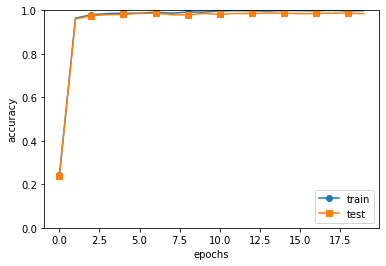

In [5]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 7.6.1 1번째 층의 가중치 시각화하기
- 합성곱 1번째 층의 가중치를 학습 전과 후로 나눠 시각화해봅니다. 이미 학습된 가중치 값(params.pkl)을 읽어서 사용하므로 학습 과정은 생략됩니다.

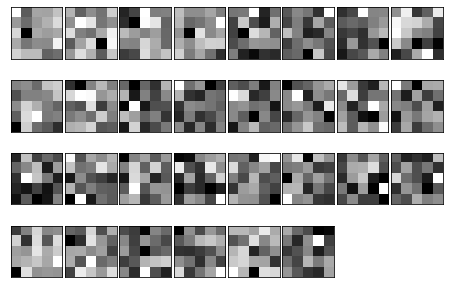

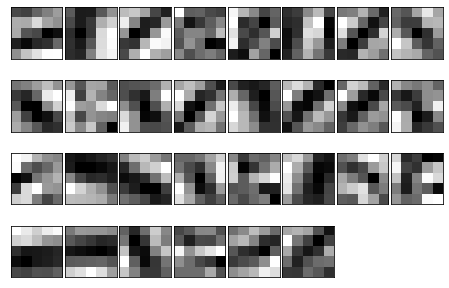

In [6]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])